# YouTube Trending Video Analysis & Prediction
### Joel Day, Caleb McCurdy, & Lane Whitmore
### The University of San Diego
### ADS 508 - Data Science Cloud Computing

In [2]:
!pip --disable-pip-version-check -q  install transformers
!pip --disable-pip-version-check -q install pyathena
!pip --disable-pip-version-check -q install sagemaker-experiments==0.1.26

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytest-astropy 0.8.0 requires pytest-cov>=2.0, which is not installed.
pytest-astropy 0.8.0 requires pytest-filter-subpackage>=0.1, which is not installed.
sagemaker 2.145.0 requires importlib-metadata<5.0,>=1.4.0, but you have importlib-metadata 6.1.0 which is incompatible.
sagemaker 2.145.0 requires PyYAML==5.4.1, but you have pyyaml 6.0 which is incompatible.
docker-compose 1.29.2 requires PyYAML<6,>=3.10, but you have pyyaml 6.0 which is incompatible.


In [123]:
# General imports
import pandas as pd
import numpy as np
import collections
import io
import time
from smexperiments.trial import Trial
from smexperiments.experiment import Experiment
import uuid

# nlp processing imports
import string
import re
import nltk
from transformers import DistilBertTokenizer
from transformers import DistilBertModel


# sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import s3fs

# Sagemaker imports
import sagemaker
from sagemaker import get_execution_role
from sagemaker.processing import ProcessingInput, ProcessingOutput
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.feature_store.feature_group import FeatureGroup
from sagemaker.feature_store.feature_definition import FeatureDefinition, FeatureTypeEnum
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import Rule
from sagemaker.debugger import rule_configs
from sagemaker.debugger import ProfilerRule
from sagemaker.debugger import CollectionConfig
from sagemaker.debugger import DebuggerHookConfig
from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import CategoricalParameter
from sagemaker.tuner import HyperparameterTuner
from sagemaker.analytics import HyperparameterTuningJobAnalytics
from smexperiments.tracker import Tracker



# athena connection imports
from pyathena import connect
import boto3

#import torch
from sagemaker.pytorch import PyTorch
#import torch.nn as nn
#from torch.utils.data import TensorDataset, DataLoader

In [4]:
region = boto3.Session().region_name
role = get_execution_role()
sm = boto3.Session(region_name=region).client(service_name="sagemaker", region_name=region)

In [5]:
# Set Athena for data wrangling // exploration
session = sagemaker.Session()

# this sets the bucket to the default sagemaker bucket
bucket = session.default_bucket()
print(bucket)

sagemaker-us-east-1-492991381452


In [6]:
ingest_create_athena_db_passed = False

db_name = "youtubedb"

In [7]:
# temp query storage
s3_athena = "s3://{}/athena/tmp/".format(bucket)

# file storage
youtube_dir = "s3://{}/athena/files/".format(bucket)

# creating connection to database
conn = connect(region_name=region, s3_staging_dir=s3_athena)

In [8]:
# Creating DATABASE with db_name above
create_db = "CREATE DATABASE IF NOT EXISTS {}".format(db_name)

pd.read_sql(create_db, conn)

""


In [9]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.ca_csv", conn)


ca_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.ca_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/can/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(ca_csv_create, conn)

""


In [10]:
pd.read_sql(f"SELECT * FROM {db_name}.ca_csv LIMIT 5", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,6bFc8z35sk0,I Had A Mental Breakdown And Cut Awful Bangs,2021-03-16T18:31:39Z,UCR-QYzXrZF8yFarK8wZbHog,Colleen Ballinger,23,2021-03-20T00:00:00Z,colleen ballinger|colleen|ballinger|psychosopr...,615446,33500,1155,13367,https://i.ytimg.com/vi/6bFc8z35sk0/default.jpg,False,False,None
1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
3,RoOZTKz0TsQ,The SEASON 6 BATTLEPASS is INSANE!! (100% UNLO...,2021-03-16T09:10:00Z,UCJAPcllL_VRxUiNKtaLOpzw,More SypherPK,20,2021-03-20T00:00:00Z,fortnite|fortnite battle royale|ninja|competit...,1056369,27700,1227,1854,https://i.ytimg.com/vi/RoOZTKz0TsQ/default.jpg,False,False,Today I react to the new Season 6 Battle Pass!...
4,bVnHisJl7Uc,Honest Trailers | WandaVision,2021-03-16T17:00:28Z,UCOpcACMWblDls9Z6GERVi1A,Screen Junkies,1,2021-03-20T00:00:00Z,screen junkies|fandom|honest trailers|screenju...,1012785,47974,813,3149,https://i.ytimg.com/vi/bVnHisJl7Uc/default.jpg,False,False,►►Subscribe to ScreenJunkies!► https://fandom....


In [11]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_csv", conn)


us_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string)
            
                
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ',', 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/usa/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(us_csv_create, conn)

""


In [12]:
pd.read_sql(f"SELECT * FROM {db_name}.us_csv LIMIT 5", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,t6_vawdzRok,Why no one guards Steph Curry this way | NBA F...,2022-06-12T00:49:28Z,UC3HPbvB6f58X_7SMIp6OPYw,Thinking Basketball,17,2022-06-16T00:00:00Z,NBA|NBA film analysis|NBA Analytics|Thinking B...,1202960,25427,0,1512,https://i.ytimg.com/vi/t6_vawdzRok/default.jpg,False,False,Why has Steph Curry put up such huge scoring n...
1,i7HBGz84haM,Astra rocket fails to deliver NASA TROPICS sat...,2022-06-12T18:34:09Z,UCVTomc35agH1SM6kCKzwW_g,VideoFromSpace,28,2022-06-16T00:00:00Z,[None],759798,4421,0,2031,https://i.ytimg.com/vi/i7HBGz84haM/default.jpg,False,False,Astra's 43-foot-tall (13 meters) Launch Vehicl...
2,4xam1qjx2iw,Diablo IV | Necromancer Cinematic Trailer,2022-06-12T18:01:49Z,UCxn8csYeZg6awRnZS-aqg0g,Diablo,20,2022-06-16T00:00:00Z,Blizzard|Blizzard Entertainment|Diablo|Diablo ...,350054,10531,0,1426,https://i.ytimg.com/vi/4xam1qjx2iw/default.jpg,False,False,The Necromancer rises.Command the dead with th...
3,Xr_vYZFRMzU,I Got Tinder as Minecraft Man...,2022-06-11T17:00:29Z,UC5p_l5ZeB_wGjO_yDXwiqvw,TommyInnit,20,2022-06-16T00:00:00Z,tommyinnit|minecraft|mine craft|dream minecraf...,1742075,195462,0,10042,https://i.ytimg.com/vi/Xr_vYZFRMzU/default.jpg,False,False,I downloaded Tinder for the first time. This d...
4,DUYE64rCtds,SOCCER SOFTBALL! | On-Season Kickball Series |...,2022-06-12T14:00:04Z,UCmfpaskzCglVeUpm_Ezg-Gg,dodgerfilms,17,2022-06-16T00:00:00Z,home run|dodgerfilms|kickball|first|ep 1|ever|...,506435,13299,0,548,https://i.ytimg.com/vi/DUYE64rCtds/default.jpg,False,False,INSTAGRAM ► @bobbycrosbyMERCH! ► http://softba...


In [13]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.gb_csv", conn)


gb_csv_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.gb_csv(
                video_id string,
                title string,
                publishedAt string,
                channelId string,
                channelTitle string,
                categoryId string,
                trending string,
                tags string,
                view_count string,
                likes string,
                dislikes string,
                comment_count string,
                thumbnail_link string,
                comments_disabled string,
                ratings_disabled string,
                description string
                )
            
                ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde' 
                WITH SERDEPROPERTIES (
                "separatorChar" = ",", 
                "quoteChar" = '\"',
                "escapeChar" = '\"'
                ) 
                LOCATION 's3://{bucket}/youtubeStatistics/csv/gb/'
                TBLPROPERTIES ("skip.header.line.count"="1");
"""

pd.read_sql(gb_csv_create, conn)

""


In [14]:
pd.read_sql(f"SELECT * FROM {db_name}.gb_csv LIMIT 5", conn)

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,lMBXncqJYV0,Euro 2020: Italian team returns home after tou...,2021-07-12T05:44:28Z,UC86dbj-lbDks_hZ5gRKL49Q,AFP News Agency,25,2021-07-14T00:00:00Z,1ST|IMAGES|FBL|EURO|2020|2021|AFP|NEWS|ACTU|INFO,1103798,18370,405,1929,https://i.ytimg.com/vi/lMBXncqJYV0/default.jpg,False,False,"The Italian Euro 2020 team arrives in Rome, st..."
1,SBIKp51Qhs0,Finally Asking Nailea about Vinnie Hacker | Di...,2021-07-11T17:00:10Z,UCLOEGprmycLLbyzBj2jozLg,Dixie D'Amelio,22,2021-07-14T00:00:00Z,Dixie D'Amelio|The Early Late Night Show|Naile...,932015,58047,1307,2432,https://i.ytimg.com/vi/SBIKp51Qhs0/default.jpg,False,False,Hi everyone! Welcome back to another episode o...
2,f9mdVVXPHgQ,US vs UK Jollibee | Food Wars,2021-07-11T16:00:26Z,UCwiTOchWeKjrJZw7S1H__1g,Food Insider,19,2021-07-14T00:00:00Z,INSIDER|FOOD INSIDER|Food Wars|Jolibee|Fried C...,419735,13313,137,1679,https://i.ytimg.com/vi/f9mdVVXPHgQ/default.jpg,False,False,"From calorie count to portion sizes, we ordere..."
3,kic4V8eP_iQ,"Mini Trip to London, Haul & Getting Outside",2021-07-10T18:52:11Z,UCrUbqTCagwsaP2Fmr0p1TsA,Zoe Sugg,22,2021-07-14T00:00:00Z,Zoe Sugg|vlog|Zoella|makeup|grwm|get ready wit...,548423,22944,224,320,https://i.ytimg.com/vi/kic4V8eP_iQ/default.jpg,False,False,"Mini Trip to London, Haul & Getting OutsideLin..."
4,lGI_zSBJKfg,"CHUNKZ, FILLY AND JACK EAT BAMBINO BECKYS JERK...",2021-07-10T18:00:10Z,UCSTJELgD0j0gW2_wgF_TYuA,Footasylum,24,2021-07-14T00:00:00Z,chunkz|nella rose|footasylum|does the shoe fit...,611808,25177,126,670,https://i.ytimg.com/vi/lGI_zSBJKfg/default.jpg,False,False,https://www.footasylum.com/ Subscribe if you’r...


In [15]:
pd.read_sql(f"DROP TABLE IF EXISTS {db_name}.us_json", conn)

us_json_create = f"""
CREATE EXTERNAL TABLE IF NOT EXISTS {db_name}.us_json (
                        kind string, 
                        etag string, 
                        items ARRAY< struct< kind: string, 
                                             etag: string,
                                             id: string,
                                             snippet: ARRAY< struct<
                                                            title: string,
                                                            assignable: string,
                                                            channelId: string
                                                    >>
                                        >>
                        )
                        ROW FORMAT SERDE 'org.openx.data.jsonserde.JsonSerDe'
                        WITH SERDEPROPERTIES ( 
                                                "ignore.malformed.json"="true"
                                             )
                        LOCATION 's3://{bucket}/youtubeStatistics/json/usa/US_category_id_test.json';
"""

pd.read_sql(us_json_create, conn)

""


In [16]:
query_json_us = f"""SELECT 
                    its.kind, 
                    its.etag, 
                    its.id, 
                    snt.title, 
                    snt.assignable, 
                    snt.channelId 
                    FROM {db_name}.us_json, 
                    UNNEST({db_name}.us_json.items) AS t(its),
                    UNNEST(its.snippet) AS t(snt)
                    WHERE snt.title = 'gaming';
"""

pd.read_sql(query_json_us, conn)

,kind,etag,id,title,assignable,channelId


In [17]:
statement = "SHOW DATABASES"
db_show = pd.read_sql(statement, conn)
db_show.head(5)

,database_name
0,default
1,sagemaker_featurestore
2,youtubedb
3,youtubestatistics


In [18]:
if db_name in db_show.values:
    ingest_create_athena_db_passed = True

In [19]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


## Exploratory Data Analysis

Preparing the data for exploration by adjusting the necessary column types.

### Initial Preprocesssing and transformations to visualize the data properly

#### Data Import

The data set below is created from the United States area where categoryid = 20 or 'Gaming' category on Youtube. As many of the creators under our companies umbrella do create 'Gaming' content, it is a key area for ViewBoost to focus in on. It also provides an opportunity to refine a robust deep learning neural network as there is still 37,000 records within the US Gaming segment.

In [64]:
# 20 is the category id for gaming in each country
us_gaming = pd.read_sql(f"SELECT * FROM {db_name}.us_csv WHERE us_csv.categoryid LIKE '20';", conn)
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,4xam1qjx2iw,Diablo IV | Necromancer Cinematic Trailer,2022-06-12T18:01:49Z,UCxn8csYeZg6awRnZS-aqg0g,Diablo,20,2022-06-16T00:00:00Z,Blizzard|Blizzard Entertainment|Diablo|Diablo ...,350054,10531,0,1426,https://i.ytimg.com/vi/4xam1qjx2iw/default.jpg,False,False,The Necromancer rises.Command the dead with th...
1,Xr_vYZFRMzU,I Got Tinder as Minecraft Man...,2022-06-11T17:00:29Z,UC5p_l5ZeB_wGjO_yDXwiqvw,TommyInnit,20,2022-06-16T00:00:00Z,tommyinnit|minecraft|mine craft|dream minecraf...,1742075,195462,0,10042,https://i.ytimg.com/vi/Xr_vYZFRMzU/default.jpg,False,False,I downloaded Tinder for the first time. This d...
2,UJd72ykl-Ac,Captains of Adventure - Official Sea of Thieve...,2022-06-12T18:09:48Z,UCtt2JqBTG-KoBae4F0Ay2tg,Sea of Thieves,20,2022-06-16T00:00:00Z,sea of thieves|sea of thieves anniversary|anni...,374671,25300,0,2438,https://i.ytimg.com/vi/UJd72ykl-Ac/default.jpg,False,False,Take a musical tour of what Sea of Thieves Sea...
3,94wQxtv_sAc,Diablo IV | Developer Gameplay Showcase,2022-06-12T18:08:00Z,UCxn8csYeZg6awRnZS-aqg0g,Diablo,20,2022-06-16T00:00:00Z,Blizzard|Blizzard Entertainment|Diablo|Diablo ...,604534,18353,0,3992,https://i.ytimg.com/vi/94wQxtv_sAc/default.jpg,False,False,Behold what Diablo IV has in store. 🔥The Diabl...
4,KXDG_oZPD3Y,10 BIGGEST REVEALS of Xbox Showcase 2022,2022-06-12T22:21:45Z,UCNvzD7Z-g64bPXxGzaQaa4g,gameranx,20,2022-06-16T00:00:00Z,xbox 2022 new game reveals|xbox summer games f...,677927,22050,0,1844,https://i.ytimg.com/vi/KXDG_oZPD3Y/default.jpg,False,False,The 2022 Xbox Bethesda game showcase brought u...


In [65]:
print("Length of data frame:", us_gaming.shape[0])
print("Width of data frame:", us_gaming.shape[1])
print("Initial data types:", us_gaming.dtypes)


# Change to integer
us_gaming['categoryid'] = us_gaming['categoryid'].astype(int) 
us_gaming['view_count'] = us_gaming['view_count'].astype(int)
us_gaming['likes'] = us_gaming['likes'].astype(int)
us_gaming['dislikes'] = us_gaming['dislikes'].astype(int)
us_gaming['comment_count'] = us_gaming['comment_count'].astype(int)


# Change to bool then int representations
us_gaming['ratings_disabled'] = us_gaming['ratings_disabled'].astype(bool).apply(int)
us_gaming['comments_disabled'] = us_gaming['comments_disabled'].astype(bool).apply(int)



# Change to datetime
us_gaming['publishedat'] = pd.to_datetime(us_gaming['publishedat'], infer_datetime_format=True)
us_gaming['trending'] = pd.to_datetime(us_gaming['trending'], infer_datetime_format=True)



print(us_gaming.isnull().sum())
print("New data types:", us_gaming.dtypes)
us_gaming.head()

Length of data frame: 37071
Width of data frame: 16
Initial data types: video_id             object
title                object
publishedat          object
channelid            object
channeltitle         object
categoryid           object
trending             object
tags                 object
view_count           object
likes                object
dislikes             object
comment_count        object
thumbnail_link       object
comments_disabled    object
ratings_disabled     object
description          object
dtype: object
video_id                0
title                   0
publishedat             0
channelid               0
channeltitle            0
categoryid              0
trending                0
tags                    0
view_count              0
likes                   0
dislikes                0
comment_count           0
thumbnail_link          0
comments_disabled       0
ratings_disabled        0
description          1296
dtype: int64
New data types: video_id             

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,4xam1qjx2iw,Diablo IV | Necromancer Cinematic Trailer,2022-06-12 18:01:49,UCxn8csYeZg6awRnZS-aqg0g,Diablo,20,2022-06-16,Blizzard|Blizzard Entertainment|Diablo|Diablo ...,350054,10531,0,1426,https://i.ytimg.com/vi/4xam1qjx2iw/default.jpg,1,1,The Necromancer rises.Command the dead with th...
1,Xr_vYZFRMzU,I Got Tinder as Minecraft Man...,2022-06-11 17:00:29,UC5p_l5ZeB_wGjO_yDXwiqvw,TommyInnit,20,2022-06-16,tommyinnit|minecraft|mine craft|dream minecraf...,1742075,195462,0,10042,https://i.ytimg.com/vi/Xr_vYZFRMzU/default.jpg,1,1,I downloaded Tinder for the first time. This d...
2,UJd72ykl-Ac,Captains of Adventure - Official Sea of Thieve...,2022-06-12 18:09:48,UCtt2JqBTG-KoBae4F0Ay2tg,Sea of Thieves,20,2022-06-16,sea of thieves|sea of thieves anniversary|anni...,374671,25300,0,2438,https://i.ytimg.com/vi/UJd72ykl-Ac/default.jpg,1,1,Take a musical tour of what Sea of Thieves Sea...
3,94wQxtv_sAc,Diablo IV | Developer Gameplay Showcase,2022-06-12 18:08:00,UCxn8csYeZg6awRnZS-aqg0g,Diablo,20,2022-06-16,Blizzard|Blizzard Entertainment|Diablo|Diablo ...,604534,18353,0,3992,https://i.ytimg.com/vi/94wQxtv_sAc/default.jpg,1,1,Behold what Diablo IV has in store. 🔥The Diabl...
4,KXDG_oZPD3Y,10 BIGGEST REVEALS of Xbox Showcase 2022,2022-06-12 22:21:45,UCNvzD7Z-g64bPXxGzaQaa4g,gameranx,20,2022-06-16,xbox 2022 new game reveals|xbox summer games f...,677927,22050,0,1844,https://i.ytimg.com/vi/KXDG_oZPD3Y/default.jpg,1,1,The 2022 Xbox Bethesda game showcase brought u...


In [66]:
us_gaming.drop_duplicates('video_id', keep = 'last', inplace = True)

In [67]:
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
162,-3oOSw49i2o,World’s *STRONGEST* Objects vs Hydraulic Press...,2022-06-15 21:16:22,UCyeVfsThIHM_mEZq7YXIQSQ,MoreAliA,20,2022-06-19,[None],955469,25689,0,837,https://i.ytimg.com/vi/-3oOSw49i2o/default.jpg,1,1,World’s *STRONGEST* Objects vs Hydraulic Press...
163,c2Gog6X755w,HANDCUFFED for 24 HOURS in REAL LIFE! w/ Squad,2022-06-15 23:00:12,UCS7b93ZwoL1xt2hR7a7l2mg,InquisitorMaster,20,2022-06-19,roblox|inquisitor master roblox|roblox inquisi...,682299,31915,0,2611,https://i.ytimg.com/vi/c2Gog6X755w/default.jpg,1,1,Today I was in a silly goofy mood and decided ...
207,Eh-Tg1seDUg,Minecraft but I Can’t Leave this Circle,2022-06-16 15:29:48,UCKGNVB2moP-zeAWPmw8HvAA,Craftee,20,2022-06-20,minecraft|minecraft but|new minecraft|craftee|...,2074307,61364,0,2321,https://i.ytimg.com/vi/Eh-Tg1seDUg/default.jpg,1,1,Playing Minecraft while I Can't Leave this Cir...
210,eLwt8FZ897c,Minecraft but Among Us Custom Hearts,2022-06-17 10:00:24,UCMYevdNaWmPbuIB0PdPc9ZQ,ZMDE Gaming,20,2022-06-20,zmde|zmde animations|minecraft|minecraft but|n...,892678,14207,0,641,https://i.ytimg.com/vi/eLwt8FZ897c/default.jpg,1,1,Subscribe for new videos every week! https://w...
212,g_nkWEH1Rts,The Sims 4: Werewolves Honest Review,2022-06-15 18:34:31,UC_IkRi_16jttcsqXxAm4YUA,Plumbella,20,2022-06-20,plumbella|sims 4|sims 4 lets build|Sims 4 lp|s...,345628,21572,0,1763,https://i.ytimg.com/vi/g_nkWEH1Rts/default.jpg,1,1,Presented by EA Creator NetworkRE THE GLITCH: ...


In [68]:
us_gaming['description'].fillna("not available", inplace = True)
us_gaming.isna().sum()

video_id             0
title                0
publishedat          0
channelid            0
channeltitle         0
categoryid           0
trending             0
tags                 0
view_count           0
likes                0
dislikes             0
comment_count        0
thumbnail_link       0
comments_disabled    0
ratings_disabled     0
description          0
dtype: int64

In [69]:
print(us_gaming['ratings_disabled'].value_counts())
print(us_gaming['comments_disabled'].value_counts())

1    6830
Name: ratings_disabled, dtype: int64
1    6830
Name: comments_disabled, dtype: int64


#### Binning View Count for Categorical Prediction Using NLP

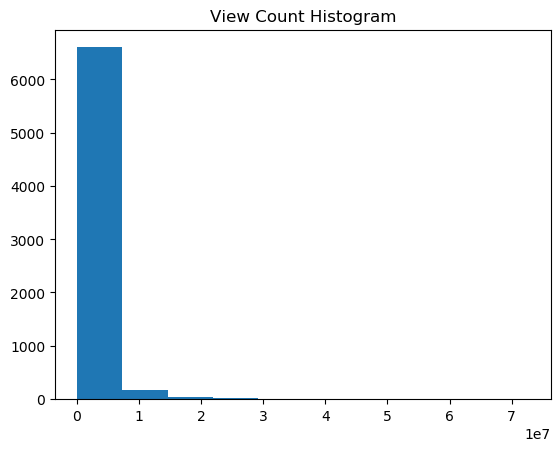

In [70]:
plt.hist(us_gaming['view_count'])
plt.title("View Count Histogram")
plt.show()

Looking at the counts below, BoostView is very interested in the difference between say an 800,000 view video and an over 1 Million view video. Splitting the data here to create a binary response variable would benefit BoostView's primary goal. Their main purpose is to make their content creators go from 600k - 800k view count to over a million. Binning the response variable view count at 1 million will also allow for confidence probabilities to be created that will hopefully point to how title can be used to predict less than a million or more than a million views for BoostView's creators

In [71]:
print("Mean View Count: ", us_gaming['view_count'].mean())
print("Median View Count: ", us_gaming['view_count'].median())
print("Max View Count: ", us_gaming['view_count'].max())
print("Min View Count", us_gaming['view_count'].min())


print("Count of videos with less than 1 Million views: ", len(us_gaming[us_gaming['view_count']<1000000]))
print("Count of videos with more than 1 Million views: ", len(us_gaming[us_gaming['view_count']>=1000000]))

print("Count of videos with less than 100,000 views: ", len(us_gaming[us_gaming['view_count']<=100000]))
print("Count of videos with more than 10 Million views: ", len(us_gaming[us_gaming['view_count']>=10000000]))

Mean View Count:  1814546.5859443631
Median View Count:  941768.5
Max View Count:  72681293
Min View Count 81296
Count of videos with less than 1 Million views:  3561
Count of videos with more than 1 Million views:  3269
Count of videos with less than 100,000 views:  6
Count of videos with more than 10 Million views:  133


In [72]:
us_gaming['cat_view_count'] = pd.cut(us_gaming['view_count'],[0,1000000,100000000], labels = [0,1])

In [73]:
us_gaming.head()

,video_id,title,publishedat,channelid,channeltitle,categoryid,trending,tags,view_count,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,cat_view_count
162,-3oOSw49i2o,World’s *STRONGEST* Objects vs Hydraulic Press...,2022-06-15 21:16:22,UCyeVfsThIHM_mEZq7YXIQSQ,MoreAliA,20,2022-06-19,[None],955469,25689,0,837,https://i.ytimg.com/vi/-3oOSw49i2o/default.jpg,1,1,World’s *STRONGEST* Objects vs Hydraulic Press...,0
163,c2Gog6X755w,HANDCUFFED for 24 HOURS in REAL LIFE! w/ Squad,2022-06-15 23:00:12,UCS7b93ZwoL1xt2hR7a7l2mg,InquisitorMaster,20,2022-06-19,roblox|inquisitor master roblox|roblox inquisi...,682299,31915,0,2611,https://i.ytimg.com/vi/c2Gog6X755w/default.jpg,1,1,Today I was in a silly goofy mood and decided ...,0
207,Eh-Tg1seDUg,Minecraft but I Can’t Leave this Circle,2022-06-16 15:29:48,UCKGNVB2moP-zeAWPmw8HvAA,Craftee,20,2022-06-20,minecraft|minecraft but|new minecraft|craftee|...,2074307,61364,0,2321,https://i.ytimg.com/vi/Eh-Tg1seDUg/default.jpg,1,1,Playing Minecraft while I Can't Leave this Cir...,1
210,eLwt8FZ897c,Minecraft but Among Us Custom Hearts,2022-06-17 10:00:24,UCMYevdNaWmPbuIB0PdPc9ZQ,ZMDE Gaming,20,2022-06-20,zmde|zmde animations|minecraft|minecraft but|n...,892678,14207,0,641,https://i.ytimg.com/vi/eLwt8FZ897c/default.jpg,1,1,Subscribe for new videos every week! https://w...,0
212,g_nkWEH1Rts,The Sims 4: Werewolves Honest Review,2022-06-15 18:34:31,UC_IkRi_16jttcsqXxAm4YUA,Plumbella,20,2022-06-20,plumbella|sims 4|sims 4 lets build|Sims 4 lp|s...,345628,21572,0,1763,https://i.ytimg.com/vi/g_nkWEH1Rts/default.jpg,1,1,Presented by EA Creator NetworkRE THE GLITCH: ...,0


### Final drops from the dataset and preparing the test set for later use for confusion matrix

In [74]:
gaming = us_gaming.drop(columns = ['ratings_disabled', 'comments_disabled', 'thumbnail_link','publishedat','channelid',
                                   'channeltitle','categoryid','trending','likes','dislikes','comment_count'])

gaming.shape

(6830, 6)

In [75]:
gaming.head(1)

,video_id,title,tags,view_count,description,cat_view_count
162,-3oOSw49i2o,World’s *STRONGEST* Objects vs Hydraulic Press...,[None],955469,World’s *STRONGEST* Objects vs Hydraulic Press...,0


In [76]:
gaming, gaming_test = train_test_split(gaming, test_size = 0.05, random_state = 52)

print(gaming.shape)
print(gaming_test.shape)

(6488, 6)
(342, 6)


### Storing for transformation later

In [77]:
s3_client = boto3.client("s3")
KEY='youtubeStatistics/cat_dfs/train/gaming.csv'
testKEY='youtubeStatistics/cat_dfs/test/gaming_test.csv'
BUCKET= session.default_bucket()

with io.StringIO() as csv_buffer:
    gaming.to_csv(csv_buffer, index=False, header=True)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=KEY, Body=csv_buffer.getvalue()
    )
    
with io.StringIO() as csv_buffer:
    gaming_test.to_csv(csv_buffer, index=False, header=True)

    response = s3_client.put_object(
        Bucket=BUCKET, Key=testKEY, Body=csv_buffer.getvalue()
    )

In [78]:
stopwords = nltk.corpus.stopwords.words(['english'])
ps = nltk.PorterStemmer()
extra_stops = ['00','000','007','01','02','03','04','06','07','09sharkboy','10','100','1000','10000','100000','1000000',
               '000001','001','002','004','008','011','013','031','036','037','05','050','062','08','09','094',
               '1001','1006','101','102','103','1050','10m','10t','10th','10x','11','119','12','120','12240','13','132',
               '133','13th','14','1400','140ms','15','150','150k','15th','16','1600','17', '175','18','1800','183','184',
               '188','189','18c','19','19500','20','200','21','2100','2163','21w05a','21w05b','21w06a','21w07a','21w07b',
               '21w08a','21w08b','21w09a','21w13a','21w13b','21w14a','21w14b','22','22w11a','22w13oneblockatatime','22w42a',
               '22w42b','23','23w04a','23w04b','24','25','25000','2500hp','25th','26','27','28','29','2900','296','2b','2b2t',
               '2bt2','2e','31','3100','31415','32','3200','33','34','35','35th','36','360','3600','365','37','3700','39','3900',
               '30th','40','400','4000','40000','4200','43','44','4400','46','4900','4logj','4logshell','4th','4x21','4x28','50',
               '500','5000','50000','505','510mph','52nd','5300','55','56','59','5e','5g','5n','5th','5up','60','600','30','300',
               '3000','303','63','6323','64','64dd','68','69','6a6y','6acc','6locc','6lue','70','700','7000','343i','34547','73',
               '7348951','74','77','781','7900','7th','80','8000','80s','82','84','85','87','876','876tv','898','8bitryan','900',
               '90s','93','94','96','97','99','999','9th','a380','a6d','a750','abc','adc','2006','2007','2007scape','2008','201',
               '2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','202','2020','2021','2022','2023','2030','2042',
               '2045','2050','2077','20th','107','109','1236','1250','128','147','14th','152','157','163','167','179','18th','1909',
               '19931','19th','1ft','1k','1st','1½','2000','2032','217','219','21st','221129','221130','23rd','240','248','250','25688',
               '25k','26th','27th','41','42','425','438','45','4500hp','47','474','48','489','49','136','143','16th','2nd','2wei','3070',
               '3080','3090','30k','348','3500','355','38','4070','4080','4090','40k','4e','51','52','53','54','542','560','562','567',
               '568','570','571','572','575','576','577','58','585','594','6000','61','623','65','66','673','694','6th','40th','7096',
               '71','72','746','75','750','76m','79','7m','800','800x600','817','851','8th','90','91','925','951','97m','996','aang','aau',
               'acnient','anymore','almost','bel','티원롤','파피플레이타임','펌킨','프나펌','프레디','프레디의','피규어','피자가게','허기워기',
               '오징어','제이홉','채색','커스텀','케플러','키즈','탱크맨','티빙에서스트리밍','티원','프라이데이']

for i in extra_stops:
    stopwords.append(i)

vectag = CountVectorizer(stop_words = stopwords)
vecti = CountVectorizer(stop_words = stopwords)
vecdes = CountVectorizer(stop_words = stopwords)

In [79]:
tag = us_gaming['tags']
title = us_gaming['title']
description = us_gaming['description']

tags = vectag.fit_transform(tag)
titles = vecti.fit_transform(title)

# printing shape of the vectors
print(tags.shape)
print(titles.shape)

# creating df from new extracted string values
tag_df = pd.DataFrame(tags.todense(), columns = vectag.get_feature_names())
title_df = pd.DataFrame(titles.todense(), columns = vecti.get_feature_names())

(6830, 11495)
(6830, 6044)


In [80]:
def length_of_string(column): 
    length = list()
    for i in us_gaming[column]:
         length.append(len(i))
    return length

In [81]:
length_of_description = length_of_string("description")
length_of_tags = length_of_string("tags")
length_of_title = length_of_string("title")

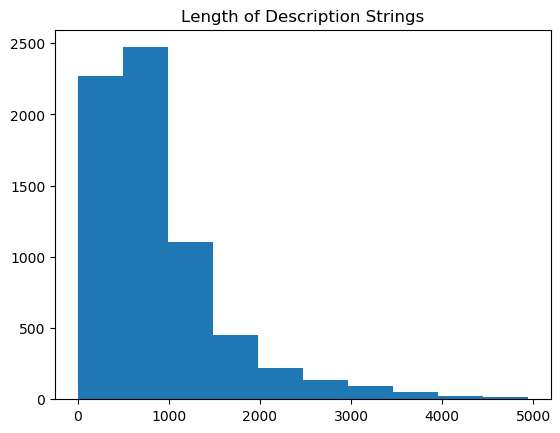

In [82]:
plt.hist(length_of_description)
plt.title("Length of Description Strings")
plt.show()

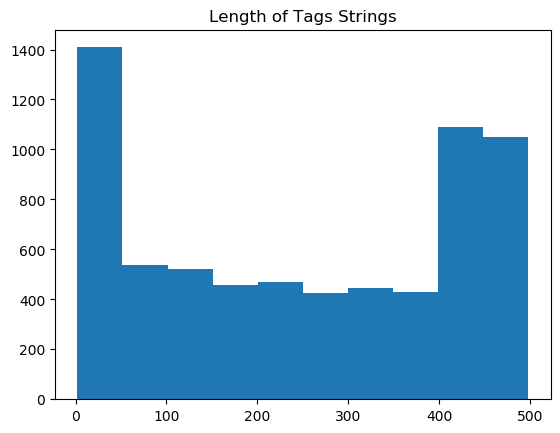

In [83]:
plt.hist(length_of_tags)
plt.title("Length of Tags Strings")
plt.show()

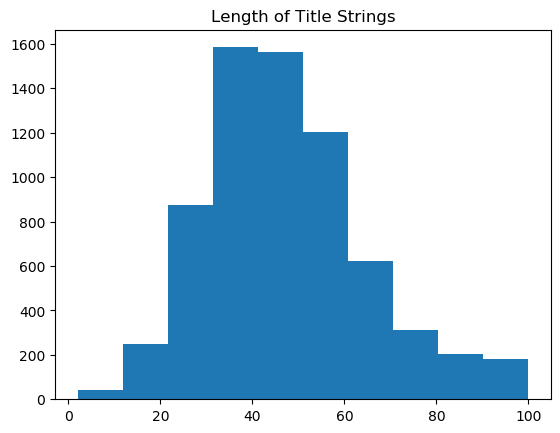

In [84]:
plt.hist(length_of_title)
plt.title("Length of Title Strings")
plt.show()

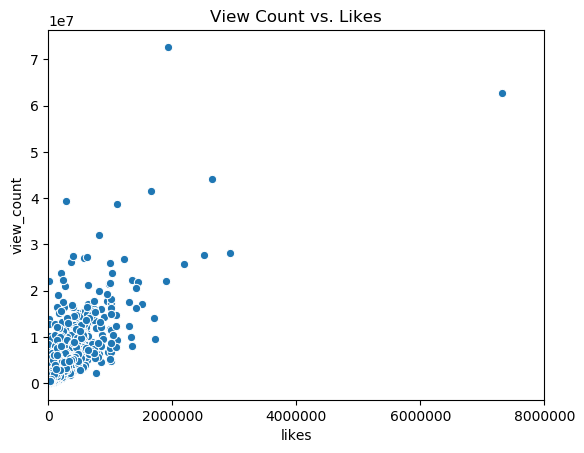

In [85]:
fig, ax = plt.subplots()

sns.scatterplot(data = us_gaming, x = "likes", y = "view_count", ax = ax)
plt.title("View Count vs. Likes")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

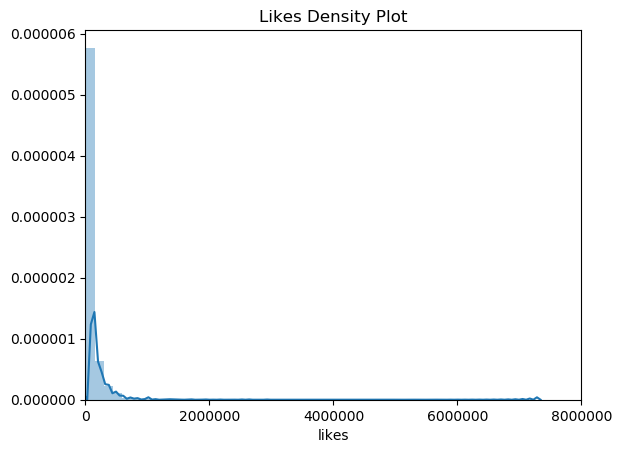

In [86]:
fig, ax = plt.subplots()

sns.distplot(us_gaming.likes, ax = ax)
plt.title("Likes Density Plot")
ax.set_xlim(0, 8000000)
ax.set_xticks([0, 2000000, 4000000, 6000000, 8000000])
plt.show()

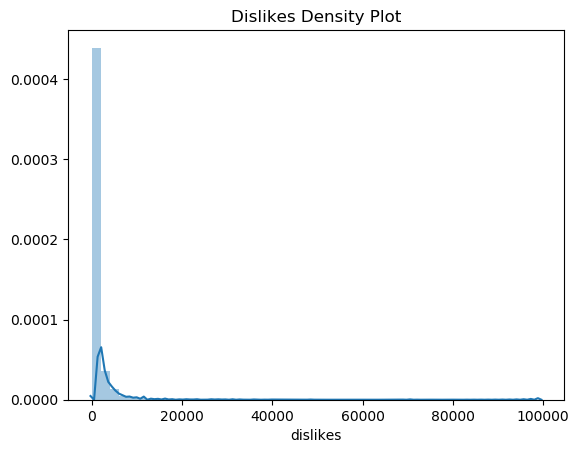

In [87]:
sns.distplot(us_gaming.dislikes)
plt.title("Dislikes Density Plot")
plt.show()

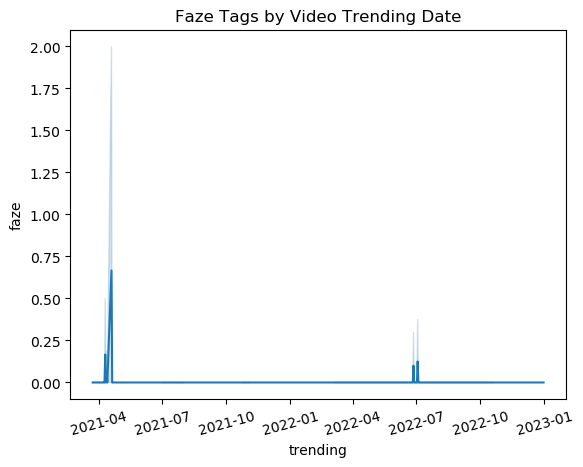

In [88]:
sns.lineplot(x = us_gaming["trending"], y = title_df["faze"])
plt.xticks(rotation = 15)
plt.title("Faze Tags by Video Trending Date")
plt.show()

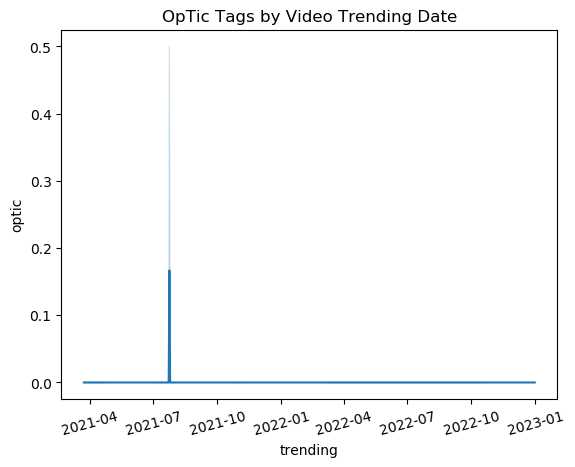

In [94]:
sns.lineplot(x = us_gaming['trending'], y = title_df['optic'])
plt.xticks(rotation = 15)
plt.title("OpTic Tags by Video Trending Date")
plt.show()

Below the recently developed game Valorant is compared to Mario, one of the most popular games in existence. Mario games are more likely to trend on any given day as the time series is much more dense, but the peaks of Valorant are slightly higher. Both of these games could viably be a valuable addition to a creator's video title.

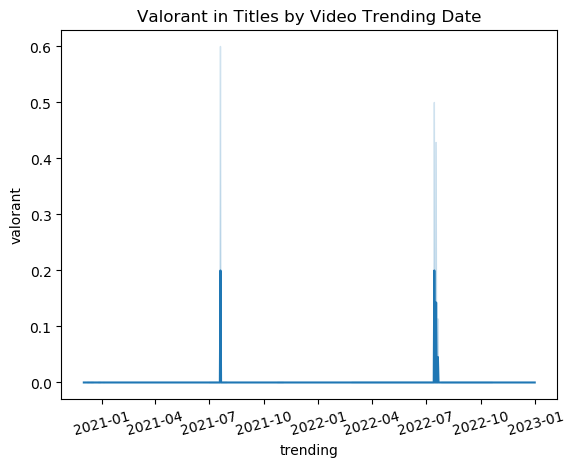

In [40]:
sns.lineplot(x = us_gaming['trending'], y = title_df['valorant'])
plt.xticks(rotation = 15)
plt.title("Valorant in Titles by Video Trending Date")
plt.show()

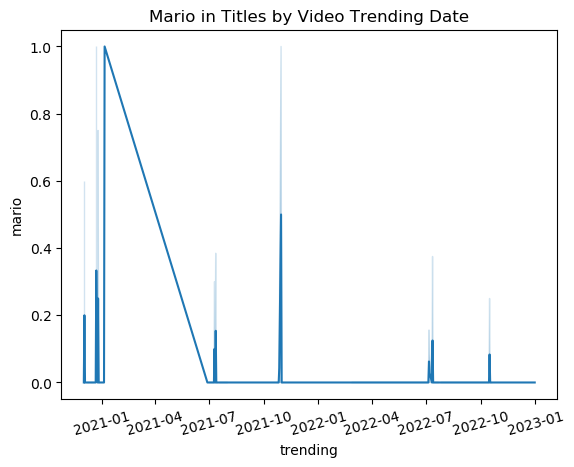

In [41]:
sns.lineplot(x = us_gaming['trending'], y = title_df['mario'])
plt.xticks(rotation = 15)
plt.title("Mario in Titles by Video Trending Date")
plt.show()

### Feature Selection Final Decisions

Ultimately, as the goal of the project is to predict views, dislikes, likes, comment count, posting date, trending date, channelid, channel title, and thumbnail link cannot be used as predictors because we hope to predict the view count of the video before the video is posted. Perhaps in future projects an image recognition model can be used to predict views based upon thumbnail photos, but this project will be limited to text. Going forward, NLP techinques will be used to create a deep learning regression model from any combination of title, tags, and description in order to predict view count on videos as view count leads to greater growth for the creators. Particularly because, as the first scatterplot reveals above, high view count often lead to high likes which in turn leads to being boosted on the trending algorithm. The more eyes on the video, the more likely to trend.

## Tokenization Transformations to Implement Deep Learning Modeling
Below is a multi-step SKlearn processing container that will do the following:

1. Grab the gaming.csv from the s3 bucket where it was stored above.

2. split the data using train/test/validation with 85/10/5 split

3. Commit the data to pre-processing transformations with distilBert and tensorflow. The data will be tokenized to extract ids and masks for title, tags, and description using distilbert. Then these ids and masks will be converted to tensorflow features and dataset in addition to view_count and video_id. This has been tracked using timestamps in the data column as well.

4. The newly transformed data is then stored in the output folder the output s3 bucket that is listed below.

In [8]:
# Timestamp the names of the different segments for tracking purposes over time.
timestamp = int(time.time())

# Creating the experiment for Youtube view count
experiment = Experiment.create(
    experiment_name="YouTube-View-Prediction-BERT-{}".format(timestamp),
    description="YouTube View Prediction with BERT",
    sagemaker_boto_client=sm,
)

# printing the experiment name
experiment_name = experiment.experiment_name
print("Experiment name: {}".format(experiment_name))

Experiment name: YouTube-View-Prediction-BERT-1681341510


In [9]:
# timestamp trial
timestamp = int(time.time())

# Creating trial using the experiment name and sagemaker
trial = Trial.create(
    trial_name="trial-{}".format(timestamp), experiment_name=experiment_name, sagemaker_boto_client=sm
)

# printing trial name
trial_name = trial.trial_name
print("Trial name: {}".format(trial_name))

Trial name: trial-1681341510


In [10]:
# store the trial name for later
%store trial_name

Stored 'trial_name' (str)


In [11]:
# setting the experiment configuration
experiment_config = {
    "ExperimentName": experiment_name,
    "TrialName": trial_name,
    "TrialComponentDisplayName": "prepare",
}

In [12]:
# starting the feature store runtime within sagemaker
featurestore_runtime = boto3.Session().client(service_name="sagemaker-featurestore-runtime", region_name=region)

In [13]:
# timestamp prefix 
timestamp = int(time.time())

# setting the future store prefix for use in df-to-tokens-to-tensors.py file
feature_store_offline_prefix = "videos-feature-store-" + str(timestamp)

# print the full name of prefix
print(feature_store_offline_prefix)

videos-feature-store-1681341511


In [14]:
# create feature group name 
feature_group_name = "videos-feature-group-" + str(timestamp)

print(feature_group_name)

videos-feature-group-1681341511


In [15]:
# writing out our feature definitions to assign them to feature stores
# these definitions are for after the features have been transformed and prepped in addition to `date` that acts as the timestamp for the feature store
feature_definitions = [
    FeatureDefinition(feature_name="title_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="title_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="tags_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="tags_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="desc_input_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="desc_input_mask", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="cat_view_count_id", feature_type=FeatureTypeEnum.INTEGRAL),
    FeatureDefinition(feature_name="segment_ids", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="video_id", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="date", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="split_type", feature_type=FeatureTypeEnum.STRING),
    FeatureDefinition(feature_name="cat_view_count", feature_type=FeatureTypeEnum.INTEGRAL),
]

In [16]:
# creating the feature group using the name and definition assigned above
feature_group = FeatureGroup(name=feature_group_name, feature_definitions=feature_definitions, sagemaker_session=session)

print(feature_group)

FeatureGroup(name='videos-feature-group-1681341511', sagemaker_session=<sagemaker.session.Session object at 0x7f2e23f95890>, feature_definitions=[FeatureDefinition(feature_name='title_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='title_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='tags_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='tags_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='desc_input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='desc_input_mask', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='cat_view_count_id', feature_type=<FeatureTypeEnum.INTEGRAL: 'Integral'>), FeatureDefinition(feature_name='segment_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='video_id', feature_ty

In [17]:
# setting the instance type and establishing our train/validation splits
# max_seq_length may need to be adjusted
processing_instance_type = "ml.c5.xlarge"
processing_instance_count = 2
train_split_percentage = 0.90
validation_split_percentage = 0.1
max_seq_length = 80
balance_dataset = True

In [18]:
# creating the Sklearn processor to run the df-to-tokens-to-tensors.py file

processor = SKLearnProcessor(
    framework_version="0.23-1",
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={"AWS_DEFAULT_REGION": region},
    max_runtime_in_seconds=7200,
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3


In [19]:
# setting the processors inputs and outputs
processor.run(
    code="text-to-TensorFlow.py",
    inputs=[
        ProcessingInput(
            input_name="gaming",
            source="s3://{}/youtubeStatistics/cat_dfs/".format(bucket),
            destination="/opt/ml/processing/input/data/",
            s3_data_distribution_type="ShardedByS3Key",
        )
    ],
    outputs=[
        ProcessingOutput(
            output_name="bert-train", 
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/train"
        ),
        ProcessingOutput(
            output_name="bert-validation",
            s3_upload_mode="EndOfJob",
            source="/opt/ml/processing/output/bert/validation"
        ),
        ProcessingOutput(
            output_name="bert-test", 
            s3_upload_mode="EndOfJob", 
            source="/opt/ml/processing/output/bert/test"
        ),
    ],
    arguments=[
        "--train-split-percentage",
        str(train_split_percentage),
        "--validation-split-percentage",
        str(validation_split_percentage),
        "--max-seq-length",
        str(max_seq_length),
        "--feature-store-offline-prefix",
        str(feature_store_offline_prefix),
        "--balance-dataset",
        str(balance_dataset),
        "--feature-group-name",
        str(feature_group_name),
    ],
    experiment_config=experiment_config,
    logs=True,
    wait=False,
)

INFO:sagemaker:Creating processing-job with name sagemaker-scikit-learn-2023-04-12-23-18-33-352


In [20]:
scikit_processing_job_name = processor.jobs[-1].describe()["ProcessingJobName"]
print(scikit_processing_job_name)

sagemaker-scikit-learn-2023-04-12-23-18-33-352


In [21]:
running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name, sagemaker_session=session
)

processing_job_description = running_processor.describe()

print(processing_job_description)

{'ProcessingInputs': [{'InputName': 'gaming', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-492991381452/youtubeStatistics/cat_dfs/', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-492991381452/sagemaker-scikit-learn-2023-04-12-23-18-33-352/input/code/text-to-TensorFlow.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}], 'ProcessingOutputConfig': {'Outputs': [{'OutputName': 'bert-train', 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-492991381452/sagemaker-scikit-learn-2023-04-12-23-18-33-352/output/bert-train', 'LocalPath': '/opt/ml/processing/output/bert/train', 'S3UploadMode': 'EndOfJob'}, 'AppManaged': False}, {'OutputName': '

In [22]:
# logs can be set to true to find errors when trouble shooting
running_processor.wait(logs=False)

...................................................................................................................................................................................!

In [23]:
# obtain the location of the new s3 folders for the training/testing/validation data in order to implement modeling
processing_job_description = running_processor.describe()

output_config = processing_job_description["ProcessingOutputConfig"]
for output in output_config["Outputs"]:
    if output["OutputName"] == "bert-train":
        processed_train_uri = output["S3Output"]["S3Uri"]
    if output["OutputName"] == "bert-validation":
        processed_validation_uri = output["S3Output"]["S3Uri"]
        
print(processed_train_uri)
print(processed_validation_uri)

s3://sagemaker-us-east-1-492991381452/sagemaker-scikit-learn-2023-04-12-23-18-33-352/output/bert-train
s3://sagemaker-us-east-1-492991381452/sagemaker-scikit-learn-2023-04-12-23-18-33-352/output/bert-validation


## Modeling / Tuning

### Tuning the Model Using a Hyperparameter Job

In [24]:
!aws s3 ls $processed_train_uri/

2023-04-12 23:33:37    5984523 part-algo-1-gaming.tfrecord


In [25]:
!aws s3 ls $processed_validation_uri/

2023-04-12 23:33:37     635584 part-algo-1-gaming.tfrecord


In [26]:
input_train_data = TrainingInput(processed_train_uri+"/", distribution="ShardedByS3Key")
input_validation_data = TrainingInput(s3_data=processed_validation_uri+"/", distribution="ShardedByS3Key")

print(input_train_data.config)
print(input_validation_data.config)

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-492991381452/sagemaker-scikit-learn-2023-04-12-23-18-33-352/output/bert-train/', 'S3DataDistributionType': 'ShardedByS3Key'}}}
{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix', 'S3Uri': 's3://sagemaker-us-east-1-492991381452/sagemaker-scikit-learn-2023-04-12-23-18-33-352/output/bert-validation/', 'S3DataDistributionType': 'ShardedByS3Key'}}}


In [96]:
tracker_optimize = Tracker.create(display_name="optimize", sagemaker_boto_client=sm)

optimize_trial_component_name = tracker_optimize.trial_component.trial_component_name
print("Optimize trial component name {}".format(optimize_trial_component_name))

Optimize trial component name TrialComponent-2023-04-13-014415-edbr


In [97]:
trial.add_trial_component(tracker_optimize.trial_component)

In [37]:
epochs = 2
learning_rate = 0.0001
epsilon = 0.000001
train_batch_size =128
validation_batch_size = 128
train_steps_per_epoch = 10
validation_steps = 10
train_instance_count = 1
train_instance_type = "ml.p2.xlarge"
train_volume_size = 1024
use_xla = True
use_amp = True
freeze_bert_layer = False
enable_sagemaker_debugger = False
enable_checkpointing = False
enable_tensorboard = False
input_mode = "File"
run_validation = True
run_sample_predictions = True

In [98]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.00001, 0.005, scaling_type="Linear"),
    "epsilon": ContinuousParameter(0.000001, 0.0001, scaling_type="Linear"),
    "epochs": CategoricalParameter([2, 3, 4]),
    "train_batch_size": CategoricalParameter([32,64,128]),
   # "freeze_bert_layer": CategoricalParameter([True, False]),
}

In [99]:
metrics_definitions = [
    {"Name": "train:loss", "Regex": "loss: ([0-9\\.]+)"},
    {"Name": "train:accuracy", "Regex": "accuracy: ([0-9\\.]+)"},
    {"Name": "validation:loss", "Regex": "val_loss: ([0-9\\.]+)"},
    {"Name": "validation:accuracy", "Regex": "val_accuracy: ([0-9\\.]+)"},
]

In [100]:
estimator = TensorFlow(
    entry_point="model.py",
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    py_version="py37",
    framework_version="2.3.1",
    hyperparameters={
        #"epochs": epochs,
        "validation_batch_size": validation_batch_size,
        "train_steps_per_epoch": train_steps_per_epoch,
        "validation_steps": validation_steps,
        "use_xla": use_xla,
        "use_amp": use_amp,
        "max_seq_length": max_seq_length,
        "freeze_bert_layer": freeze_bert_layer,
        "enable_sagemaker_debugger": enable_sagemaker_debugger,
        "enable_checkpointing": enable_checkpointing,
        "enable_tensorboard": enable_tensorboard,
        "run_validation": run_validation,
        "run_sample_predictions": run_sample_predictions,
        "local_bucket": bucket,
    },
    input_mode=input_mode,
    metric_definitions=metrics_definitions,
)

In [101]:
objective_metric_name = "train:accuracy"

tuner = HyperparameterTuner(
    estimator=estimator,
    objective_type="Maximize",
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    metric_definitions=metrics_definitions,
    max_jobs=10,
    max_parallel_jobs=1,
    strategy="Bayesian",
    early_stopping_type="Auto",
)

In [102]:
tuner.fit(
    inputs={"train": input_train_data, "validation": input_validation_data},
    include_cls_metadata=False,
    wait=False,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating hyperparameter tuning job with name: tensorflow-training-230413-0144


In [103]:
tuning_job_name = tuner.latest_tuning_job.job_name

In [104]:
hp_results = HyperparameterTuningJobAnalytics(sagemaker_session=session, hyperparameter_tuning_job_name=tuning_job_name)

df_results = hp_results.dataframe()
df_results

,epochs,epsilon,learning_rate,train_batch_size,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""4""",0.000037,0.004214,"""32""",tensorflow-training-230413-0144-010-60a4b87a,Completed,0.5273,2023-04-13 02:43:32+00:00,2023-04-13 02:49:35+00:00,363.0
1,"""2""",0.000001,0.000010,"""128""",tensorflow-training-230413-0144-009-77545798,Stopped,0.4492,2023-04-13 02:40:19+00:00,2023-04-13 02:43:12+00:00,173.0
2,"""2""",0.000046,0.001510,"""128""",tensorflow-training-230413-0144-008-2cda86f7,Completed,0.5281,2023-04-13 02:34:05+00:00,2023-04-13 02:39:52+00:00,347.0
3,"""3""",0.000066,0.001418,"""64""",tensorflow-training-230413-0144-007-b83b9469,Stopped,0.4570,2023-04-13 02:28:09+00:00,2023-04-13 02:33:42+00:00,333.0
4,"""4""",0.000027,0.000092,"""128""",tensorflow-training-230413-0144-006-43adba96,Stopped,0.4352,2023-04-13 02:23:57+00:00,2023-04-13 02:26:29+00:00,152.0
5,"""2""",0.000097,0.003886,"""128""",tensorflow-training-230413-0144-005-d6417d65,Completed,0.5109,2023-04-13 02:17:42+00:00,2023-04-13 02:23:25+00:00,343.0
6,"""3""",0.000072,0.000293,"""128""",tensorflow-training-230413-0144-004-021db3f0,Completed,0.5148,2023-04-13 02:10:20+00:00,2023-04-13 02:16:43+00:00,383.0
7,"""3""",0.000096,0.004666,"""128""",tensorflow-training-230413-0144-003-3b075214,Completed,0.5008,2023-04-13 02:03:01+00:00,2023-04-13 02:09:18+00:00,377.0
8,"""2""",0.000040,0.000501,"""32""",tensorflow-training-230413-0144-002-eedf67c8,Completed,0.4953,2023-04-13 01:56:51+00:00,2023-04-13 02:02:14+00:00,323.0
9,"""4""",0.000059,0.000593,"""64""",tensorflow-training-230413-0144-001-ac3a8bff,Completed,0.4922,2023-04-13 01:46:05+00:00,2023-04-13 01:56:15+00:00,610.0


In [105]:
final_learning_rate = float(df_results.sort_values("FinalObjectiveValue", ascending=0).head(1)["learning_rate"])
print(final_learning_rate)
#final_learning_rate = 0.00001

0.0015096828866666705


In [106]:
final_epsilon = float(df_results.sort_values("FinalObjectiveValue", ascending =0).head(1)["epsilon"])
print(final_epsilon)
#final_epsilon = 0.0001

4.64434514182339e-05


In [107]:
final_epoch = df_results.sort_values("FinalObjectiveValue", ascending =0).head(1)["epochs"]
print(final_epoch)
final_epochs = 2

2    "2"
Name: epochs, dtype: object


In [108]:
final_batch =df_results.sort_values("FinalObjectiveValue", ascending =0).head(1)["train_batch_size"]

print(final_batch)

final_train_batch = 128

2    "128"
Name: train_batch_size, dtype: object


### Training the Final Model After Tuning

In [109]:
profiler_config = ProfilerConfig(system_monitor_interval_millis=500,
    framework_profile_params=FrameworkProfile(local_path="/opt/ml/output/profiler/", start_step=5, num_steps=10))

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [110]:
actions = rule_configs.ActionList()

rules = [ProfilerRule.sagemaker(rule_configs.ProfilerReport())]


hook_config = DebuggerHookConfig(
    hook_parameters={
        "save_interval": "10",  # number of steps
        "export_tensorboard": "true",
        "tensorboard_dir": "hook_tensorboard/",
    }
)

In [111]:
checkpoint_s3_prefix = "checkpoints/{}".format(str(uuid.uuid4()))
checkpoint_s3_uri = "s3://{}/{}/".format(bucket, checkpoint_s3_prefix)

print(checkpoint_s3_uri)

s3://sagemaker-us-east-1-492991381452/checkpoints/7af995bf-2e88-456f-afbe-01ec6d6947f8/


In [112]:
fin_input_mode = "Pipe"

In [113]:
fin_estimator = TensorFlow(
    entry_point="model.py",
    role=role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    volume_size=train_volume_size,
    checkpoint_base_path=checkpoint_s3_uri,
    py_version="py37",
    framework_version="2.3.1",
    hyperparameters={
        "epochs": final_epochs,
        "learning_rate": final_learning_rate,
        "epsilon": final_epsilon,
        "train_batch_size": final_train_batch,
        "validation_batch_size": validation_batch_size,
        "train_steps_per_epoch": train_steps_per_epoch,
        "validation_steps": validation_steps,
        "use_xla": use_xla,
        "use_amp": use_amp,
        "max_seq_length": max_seq_length,
        "freeze_bert_layer": freeze_bert_layer,
        "enable_sagemaker_debugger": enable_sagemaker_debugger,
        "enable_checkpointing": enable_checkpointing,
        "enable_tensorboard": enable_tensorboard,
        "run_validation": run_validation,
        "run_sample_predictions": run_sample_predictions,
        "local_bucket": bucket,
    },
    input_mode=fin_input_mode,
    metric_definitions=metrics_definitions,
    rules=rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [114]:
experiment_config = {"ExperimentName": experiment_name, "TrialName": trial_name, "TrialComponentDisplayName": "train"}

In [115]:
fin_estimator.fit(
    inputs={"train": input_train_data, "validation": input_validation_data},
    experiment_config=experiment_config,
    wait=False,
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-04-13-02-53-50-178


In [116]:
%%time

fin_estimator.latest_training_job.wait(logs=True)

2023-04-13 02:53:52 Starting - Starting the training job...
2023-04-13 02:54:25 Starting - Preparing the instances for trainingProfilerReport: InProgress
.........
2023-04-13 02:55:54 Downloading - Downloading input data...
2023-04-13 02:56:25 Training - Downloading the training image............
2023-04-13 02:58:16 Training - Training image download completed. Training in progress.....2023-04-13 02:58:59.607771: W tensorflow/core/profiler/internal/smprofiler_timeline.cc:460] Initializing the SageMaker Profiler.
2023-04-13 02:58:59.608061: I tensorflow/core/profiler/internal/smprofiler_config_reader.cc:123] PID of the process that is writing to the timeline : 8
2023-04-13 02:58:59.608115: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:121] SageMaker Profiler Timeline Writer read the following config parameters :
2023-04-13 02:58:59.608137: I tensorflow/core/profiler/internal/smprofiler_timeline.cc:122] Base Folder : /opt/ml/output/profiler/
2023-04-13 02:58:59.608149: I ten

In [119]:
fin_estimator.training_job_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:loss,0.473567
1,240.0,train:loss,0.922500
2,540.0,train:loss,0.804000
3,0.0,train:accuracy,0.814400
4,240.0,train:accuracy,0.285700
5,540.0,train:accuracy,0.415600
6,0.0,validation:loss,0.740600
7,300.0,validation:loss,0.746200
8,0.0,validation:accuracy,0.475800
9,300.0,validation:accuracy,0.468000


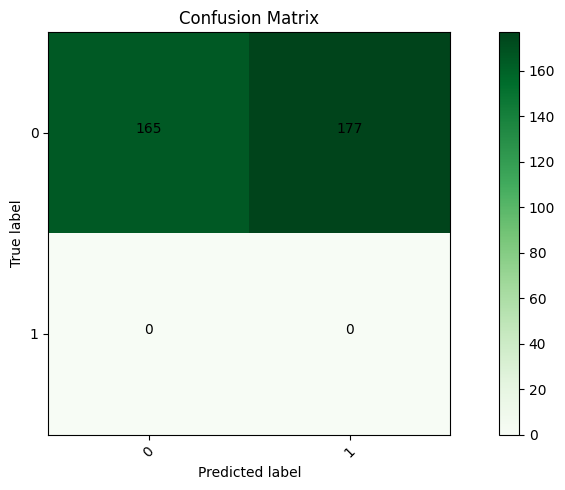

In [120]:
fs = s3fs.S3FileSystem()


fs.ls('s3://{}/data/'.format(bucket))


with fs.open('s3://{}/youtubeStatistics/confusion_matrix.png'.format(bucket)) as f:
    display(Image.open(f))

In [141]:
results = pd.read_csv("s3://{}/youtubeStatistics/results_df.csv".format(bucket))
results.head()

,Unnamed: 0,Prediction,Actual,title,video_id,view_count
0,0,0,1,Battlefield Friends 2042 We're Leaving,5FYX6i5tTew,1247919
1,1,0,1,Minecraft but its INFINITE,5y1ySOeN78M,1079544
2,2,0,0,Halo Infinite | Catalyst & Breaker – Season 2 ...,aD88v-0IKJ0,185348
3,3,0,1,The New FASTEST Editor... (Reacting to My Chal...,G0DSUiehMI4,1062946
4,4,0,0,THE BEST PERFORMANCE FROM FLIGHT EVER! 1V1 Of ...,PGpbV7SJB-4,688987


In [143]:
print(classification_report(results.Prediction, results.Actual))

              precision    recall  f1-score   support

           0       1.00      0.48      0.65       342
           1       0.00      0.00      0.00         0

    accuracy                           0.48       342
   macro avg       0.50      0.24      0.33       342
weighted avg       1.00      0.48      0.65       342



In [146]:
print("Final Model Accuracy: ", accuracy_score(results.Prediction, results.Actual).round(4))

Final Model Accuracy:  0.4825
